In [20]:
import pandas as pd
from reload_recursive import reload_recursive
import os
from loguru import logger
from pathlib import Path
import json
import numpy as np
from tqdm.notebook import tqdm
import re
import sys
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

import mri_data
import monai_training

In [2]:
reload_recursive(mri_data)
reload_recursive(monai_training)

from mri_data.file_manager import DataSet, scan_3Tpioneer_bids
from mri_data import file_manager as fm
from mri_data import utils
from monai_training.preprocess import DataSetProcesser

In [3]:
logger.remove()

In [4]:
to_load = True
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
inference_root = drive_root / "3Tpioneer_bids_predictions"
dataroot = drive_root / "3Tpioneer_bids"
clinical_data_root = drive_root / "Secure_Data" / "Large"
project_dataroot = msmri_home / "data"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary3"

### Data Cleaning

- Add column which is subid as int
- Set the index to the new column
- Remove any rows where subid is NaN
- Rename columns
- Check "Working with missing data" on pandas documentation

### Additional Data

- ROI size

In [5]:
df = pd.read_csv(curr_dir / "clinical_data_full.csv")
df = df.set_index("subid")
df.index.name = "subject_id"

df_full = df
not_nas = (~df_full['pineal_volume'].isna() & ~df_full['choroid_volume'].isna() & ~df_full['pituitary_volume'].isna())
df = df_full.loc[not_nas, :]

In [6]:
if not to_load:
    dataset_proc = DataSetProcesser.new_dataset(dataroot, scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
    full_dataset = dataset_proc.dataset
    dataset_proc.prepare_labels(["choroid_t1_flair", "pineal", "pituitary"], ["CH", "SRS", "ED", "DT"])
    dataset = dataset_proc.dataset

    inference_dataset_proc = DataSetProcesser.new_dataset(inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
    inference_dataset_proc.prepare_labels("t1_choroid_pineal_pituitary_T1-1_pred")
    inference_dataset = inference_dataset_proc.dataset

### Prepare Data

- Set categorical variables
  - ms_type
  - race
  - ethnicity
  - sex
- Set edss as ordinal variable

Do I need to factorize the categorical variables if I just set their dtype as "category"?

In [7]:
# edss is ordinal variable
# edss_type = pd.CategoricalDtype(categories=np.linspace(1, 11, 21), ordered=True)
# df['numEDSS'] = df['numEDSS'].astype(edss_type)
for i, row in df.iterrows():
    if row['edss_diff_abs'] == ".":
        df.loc[i, ['edss_diff_abs']] = None
df.loc[df['dzdur'] == "#VALUE!", "dzdur"] = None

In [8]:
try:
    df.insert(8, 'norm_pituitary_volume', df['pituitary_volume']/df['tiv'])
except ValueError:
    pass
try:
    df.insert(8, 'norm_pineal_volume', df['pineal_volume']/df['tiv'])
except ValueError:
    pass
try:
    df.insert(8, 'norm_choroid_volume', df['choroid_volume']/df['tiv'])
except ValueError:
    pass

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [9]:
try:
    df.insert(18, 'dz_type', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df.loc[df['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'
df['dz_type'].unique()

array(['RMS', 'PMS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type2` has MS versus !MS and UNK

In [10]:
try:
    df.insert(18, 'dz_type2', df['dz_type'])
except Exception:
    pass

df.loc[:, 'dz_type2'] = df['dz_type']

df.loc[df['dz_type'].isin(['RMS', 'PMS']), 'dz_type2'] = 'MS'
df['dz_type2'].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [11]:
try:
    df.insert(18, 'dz_type3', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type3'] = df['ms_type']

df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS', 'RRMS', 'CIS']), 'dz_type3'] = 'MS'
df['dz_type3'].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

## Statistical Analysis

### Descriptive Stats

In [12]:
print(len(df), "patients in total")
nRMS = sum(df['dz_type'] == "RMS")
nPMS = sum(df['dz_type'] == "PMS")
nNotMS = sum(df['dz_type'] == "!MS")
print(nRMS, "patients with RMS", f"({round(nRMS / len(df), 2)})")
print(nPMS, "patients with PMS", f"({round(nPMS / len(df), 2)})")
print(nNotMS, "patients w/o MS", f"({round(nNotMS / len(df), 2)})")

461 patients in total
308 patients with RMS (0.67)
79 patients with PMS (0.17)
69 patients w/o MS (0.15)


In [13]:
print(len(df), "patients in total")
nMS = sum(df['dz_type3'] == "MS")
nOIND = sum(df['dz_type3'] == "OIND")
nNIND = sum(df['dz_type3'] == "NIND")
print(nMS, "patients with MS", f"({round(nMS / len(df), 2)})")
print(nOIND, "patients with OIND", f"({round(nOIND / len(df), 2)})")
print(nNIND, "patients w/o NIND", f"({round(nNIND / len(df), 2)})")

461 patients in total
387 patients with MS (0.84)
28 patients with OIND (0.06)
39 patients w/o NIND (0.08)


In [14]:
print("Female subjects:     {:0.2f}".format(sum(df['sex'] == "Female") / len(df)) )
print("Average age at scan: {:0.2f}".format(df['age'].mean()))

Female subjects:     0.78
Average age at scan: 47.58


In [15]:
df_rrms = df.loc[df["dz_type"] == "RMS"]
print("RMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_rrms['sex'] == "Female") / len(df_rrms)))
print("\tAge:     {:0.2f}".format(df_rrms['age'].mean()))

df_pms = df.loc[df["dz_type"] == "PMS"]
print("PMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_pms['sex'] == "Female") / len(df_pms)))
print("\tAge:     {:0.2f}".format(df_pms['age'].mean()))

df_notms = df.loc[df["dz_type"] == "!MS"]
print("!MS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_notms['sex'] == "Female") / len(df_notms)))
print("\tAge:     {:0.2f}".format(df_notms['age'].mean()))

RMS Patients:
	Female:  0.82
	Age:     44.54
PMS Patients:
	Female:  0.58
	Age:     58.25
!MS Patients:
	Female:  0.81
	Age:     49.05


#### Volumes

In [16]:
# choroid
print("Choroid volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['choroid_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['choroid_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['choroid_volume'].mean()))

# pineal
print("Pineal volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pineal_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pineal_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pineal_volume'].mean()))

# pituitary
print("Pituitary volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pituitary_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pituitary_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pituitary_volume'].mean()))

Choroid volumes:
	RRMS:   1636.13
	PMS:    1686.45
	not-MS: 1759.73
Pineal volumes:
	RRMS:   181.47
	PMS:    150.11
	not-MS: 235.76
Pituitary volumes:
	RRMS:   631.39
	PMS:    640.51
	not-MS: 659.92


In [17]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type2'] == "MS"].choroid_volume.mean()
choroid_notms_mean = df[df['dz_type2'] == "!MS"].choroid_volume.mean()
print("\tMS:     {:0.2f}".format(choroid_ms_mean))
print("\tnot-MS: {:0.2f}".format(choroid_notms_mean))

print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_notms_mean = df[df['dz_type2'] == "!MS"].pineal_volume.mean()
print("\tMS:     {:0.2f}".format(pineal_ms_mean))
print("\tnot-MS: {:0.2f}".format(pineal_notms_mean))

print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_notms_mean = df[df['dz_type2'] == "!MS"].pituitary_volume.mean()
print("\tMS:     {:0.2f}".format(pituitary_ms_mean))
print("\tnot-MS: {:0.2f}".format(pituitary_notms_mean))

Choroid volumes:
	MS:     1646.40
	not-MS: 1759.73

Pineal volumes
	MS:     175.07
	not-MS: 235.76

Pituitary volumes
	MS:     633.25
	not-MS: 659.92


In [18]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type3'] == "MS"].choroid_volume.mean()
choroid_oind_mean = df[df['dz_type3'] == "OIND"].choroid_volume.mean()
choroid_nind_mean = df[df['dz_type3'] == "NIND"].choroid_volume.mean()
print("\tMS:   {:0.2f}".format(choroid_ms_mean))
print("\tOIND: {:0.2f}".format(choroid_oind_mean))
print("\tNIND: {:0.2f}".format(choroid_nind_mean))


print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_oind_mean = df[df['dz_type3'] == "OIND"].pineal_volume.mean()
pineal_nind_mean = df[df['dz_type3'] == "NIND"].pineal_volume.mean()
print("\tMS:   {:0.2f}".format(pineal_ms_mean))
print("\tOIND: {:0.2f}".format(pineal_oind_mean))
print("\tNIND: {:0.2f}".format(pineal_nind_mean))


print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_oind_mean = df[df['dz_type3'] == "OIND"].pituitary_volume.mean()
pituitary_nind_mean = df[df['dz_type3'] == "NIND"].pituitary_volume.mean()
print("\tMS:   {:0.2f}".format(pituitary_ms_mean))
print("\tOIND: {:0.2f}".format(pituitary_oind_mean))
print("\tNIND: {:0.2f}".format(pituitary_nind_mean))

Choroid volumes:
	MS:   1646.40
	OIND: 1752.60
	NIND: 1795.19

Pineal volumes
	MS:   175.07
	OIND: 205.06
	NIND: 263.55

Pituitary volumes
	MS:   633.25
	OIND: 646.75
	NIND: 667.03


## Plots

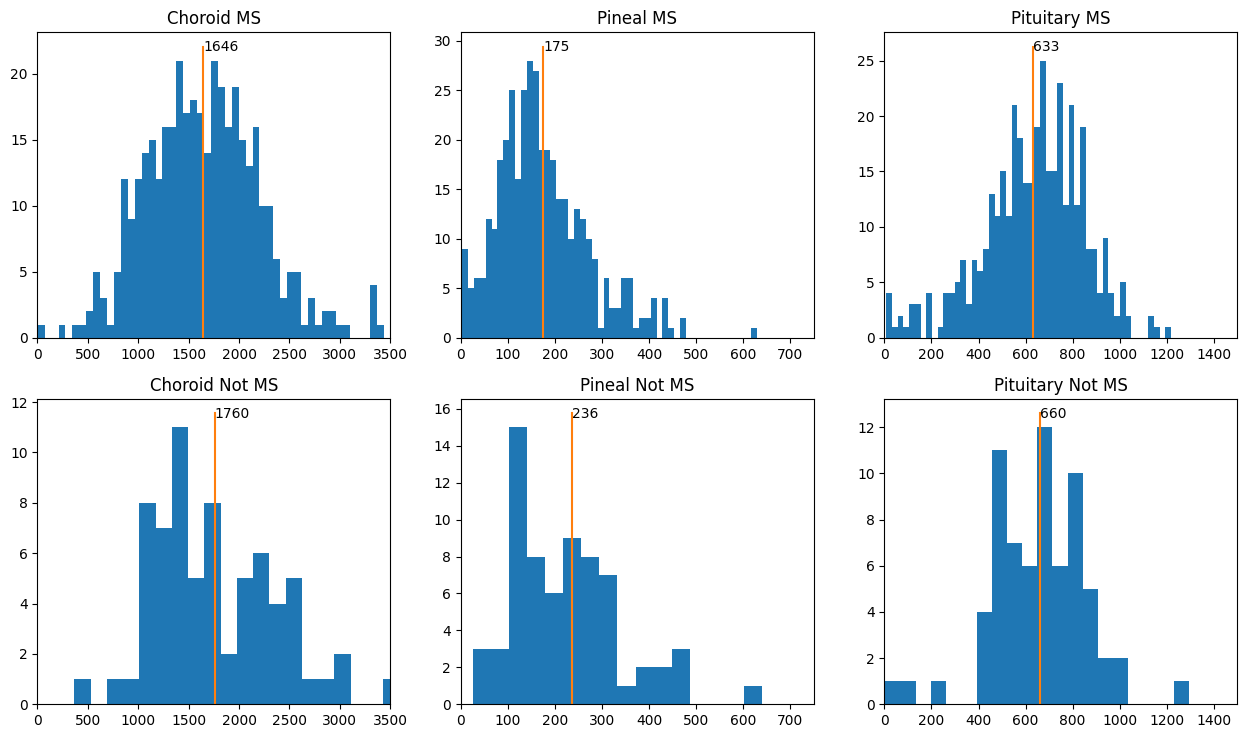

In [21]:
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df.loc[df['dz_type2']=='MS', 'choroid_volume'], bins=50)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean, choroid_ms_mean], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df['dz_type2']=='!MS', 'choroid_volume'], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean, choroid_notms_mean], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0,1].hist(df.loc[df['dz_type2']=='MS', 'pineal_volume'], bins=50)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean, pineal_ms_mean], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1,1].hist(df.loc[df['dz_type2']=='!MS', 'pineal_volume'], bins=30)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean, pineal_notms_mean], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0,2].hist(df.loc[df['dz_type2']=='MS', 'pituitary_volume'], bins=50)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1,2].hist(df.loc[df['dz_type2']=='!MS', 'pituitary_volume'], bins=20)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

## Regression Models

Covariates: age, sex, TIV, contrast

### Linear Regression on Volume

Predict volume of structure with the following predictors:

- MS vs Not-MS
- MS vs OIND vs NIND
- RMS vs PMS

#### Choroid Plexus

##### MS vs not-MS

In [19]:
volume = 'choroid_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     30.83
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           5.59e-27
Time:                        15:43:14   Log-Likelihood:                -3463.6
No. Observations:                 455   AIC:                             6939.
Df Residuals:                     449   BIC:                             6964.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            9.2628      1.868      4.959      0.0

#### MS vs NIND vs OIND

In [20]:
volume = 'choroid_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     25.88
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           2.02e-26
Time:                        15:43:20   Log-Likelihood:                -3447.8
No. Observations:                 453   AIC:                             6910.
Df Residuals:                     446   BIC:                             6938.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            9.1154      1.878      4.853      0.0

#### PMS v RMS

In [21]:
volume = 'choroid_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'RMS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     24.29
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           3.17e-21
Time:                        15:43:28   Log-Likelihood:                -2935.7
No. Observations:                 386   AIC:                             5883.
Df Residuals:                     380   BIC:                             5907.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            8.9729      2.176      4.123      0.0

### Pineal

#### MS vs not-MS

In [69]:
volume = 'pineal_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.677
Date:                Mon, 20 Jan 2025   Prob (F-statistic):              0.139
Time:                        15:37:14   Log-Likelihood:                -2864.7
No. Observations:                 479   AIC:                             5741.
Df Residuals:                     473   BIC:                             5766.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.3214      0.358     -0.897      0.3

#### MS vs NIND vs OIND

In [70]:
volume = 'pineal_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.154
Date:                Mon, 20 Jan 2025   Prob (F-statistic):             0.0463
Time:                        15:37:27   Log-Likelihood:                -2851.2
No. Observations:                 477   AIC:                             5716.
Df Residuals:                     470   BIC:                             5746.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.3337      0.360     -0.927      0.3

#### PMS v RMS

In [71]:
volume = 'pineal_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'RMS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.605
Date:                Mon, 20 Jan 2025   Prob (F-statistic):              0.158
Time:                        15:37:52   Log-Likelihood:                -2360.5
No. Observations:                 405   AIC:                             4733.
Df Residuals:                     399   BIC:                             4757.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4370      0.362     -1.207      0.2

### Pituitary

#### MS vs not-MS

In [72]:
volume = 'pituitary_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     7.593
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           7.10e-07
Time:                        15:38:13   Log-Likelihood:                -2995.1
No. Observations:                 479   AIC:                             6002.
Df Residuals:                     473   BIC:                             6027.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4413      0.470     -3.064      0.0

#### MS vs NIND vs OIND

In [73]:
volume = 'pituitary_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.599
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           1.04e-06
Time:                        15:38:25   Log-Likelihood:                -2982.6
No. Observations:                 477   AIC:                             5979.
Df Residuals:                     470   BIC:                             6008.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4815      0.474     -3.126      0.0

#### PMS v RMS

In [74]:
volume = 'pituitary_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'RMS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     6.340
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           1.11e-05
Time:                        15:38:38   Log-Likelihood:                -2524.6
No. Observations:                 405   AIC:                             5061.
Df Residuals:                     399   BIC:                             5085.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.2256      0.543     -2.259      0.0

In [138]:
volume = 'choroid_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', volume, 'edss_diff_abs', 'numEDSS']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data.loc[:, ['dz_type3_factor']], _ = data['dz_type3'].factorize(sort=False)

data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)

predictors = ['age', 'Female', 'WITH', 'MS', 'OIND', 'volume']
# predictors = ['Male']

y = data['numEDSS']
x = data[predictors]
x = np.asarray(x, dtype='float64')
x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)

res = sm.OLS(y, x).fit(missing='drop')

print(predictors, "\n")
print(res.summary())

['age', 'Female', 'WITH', 'MS', 'OIND', 'volume'] 

                            OLS Regression Results                            
Dep. Variable:                numEDSS   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     6.367
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           5.11e-06
Time:                        12:56:23   Log-Likelihood:                -573.43
No. Observations:                 164   AIC:                             1161.
Df Residuals:                     157   BIC:                             1183.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


Look at EDSS as outcome

In [141]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

volume = 'pituitary_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'numEDSS', volume, 'brain']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data.loc[:, ['dz_type3_factor']], _ = data['dz_type3'].factorize(sort=False)

data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'volume']
# predictors = ['Male']

data = data.dropna()
y = data['numEDSS']
x = data[predictors]
x = np.asarray(x, dtype='float64')

mod = OrderedModel(data['numEDSS'], x, distr='logit', disp=False)
res = mod.fit(method='bfgs')

print(predictors, "\n")
print(res.summary())

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 3.066618
         Iterations: 117
         Function evaluations: 165
         Gradient evaluations: 154
['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'volume'] 

                             OrderedModel Results                             
Dep. Variable:                numEDSS   Log-Likelihood:                -502.93
Model:                   OrderedModel   AIC:                             1084.
Method:            Maximum Likelihood   BIC:                             1205.
Date:                Mon, 20 Jan 2025                                         
Time:                        12:57:51                                         
No. Observations:                 164                                         
Df Residuals:                     125                                         
Df Model:                           7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [92]:
data['numEDSS'].dtype

CategoricalDtype(categories=[ 1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,  5.0,  5.5,
                   6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0, 10.5,
                  11.0],
, ordered=True, categories_dtype=float64)

In [ ]:
url = "https://stats.idre.ucla.edu/stat/data/ologit.dta"
data_student = pd.read_stata(url)

mod_prob = OrderedModel(data_student['apply'],
                        data_student[['pared', 'public', 'gpa']],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

In [93]:
data_student['apply'].dtype

CategoricalDtype(categories=['unlikely', 'somewhat likely', 'very likely'], ordered=True, categories_dtype=object)

In [169]:
sex = data.iloc[:30].sex
test_volume = data.iloc[:30].volume

test_df = pd.DataFrame({'sex': sex, 'volume': volume})
test_df = pd.concat((test_df, pd.get_dummies(test_df['sex'])), axis=1)
for i, row in test_df.iterrows():
    if test_df.loc[i, 'Female']:
        test_df.loc[i, 'Female'] = 1
    else:
        test_df.loc[i, 'Female'] = 0

    if row['Male']:
        test_df.loc[i, 'Male'] = 1
    else:
        test_df.loc[i, 'Male'] = 0
test_df.to_csv("test_df.csv")

/tmp/ipykernel_3054674/2023392845.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_df.loc[i, 'Female'] = 1
/tmp/ipykernel_3054674/2023392845.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_df.loc[i, 'Male'] = 0


In [203]:
female = [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
male = [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
const = [1 for i in male]
x = np.array([male, const]).transpose()
test_volume_list = [38, 345, 210, 147, 136, 150, 284, 208, 202, 244, 330, 115, 133, 400, 223, 81, 447, 277, 84, 154, 161, 177, 312, 227, 185, 144, 150, 170, 129, 116]

res = sm.GLM(test_volume_list, x).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          9022.9
Method:                          IRLS   Log-Likelihood:                -178.15
Date:                Thu, 16 Jan 2025   Deviance:                   2.5264e+05
Time:                        17:31:00   Pearson chi2:                 2.53e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04972
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            49.5466     41.003      1.208      0.2

In [177]:
sex_factor = test_df['Female'].to_list()
res = sm.OLS(test_volume, sex_factor).fit(missing='drop')

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.270
Model:                            OLS   Adj. R-squared (uncentered):              0.245
Method:                 Least Squares   F-statistic:                              10.74
Date:                Tue, 14 Jan 2025   Prob (F-statistic):                     0.00272
Time:                        17:21:16   Log-Likelihood:                         -199.71
No. Observations:                  30   AIC:                                      401.4
Df Residuals:                      29   BIC:                                      402.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

With Python statsmodels.OLS, coefficient does not flip signs when I reverse the coding of a binary variable

In [192]:
test_volume_list = [37.888454, 344.577332, 210.448578, 146.943634, 135.682953, 150.01709, 283.630951, 207.866623, 201.727509, 244.208298, 329.728058, 115.207657, 133.119675, 399.870972, 223.241089, 80.89521, 447.486877, 276.991302, 83.964966, 154.114304, 161.279999, 177.15155, 312.319214, 227.325195, 184.832458, 144.384552, 150.016571, 169.983566, 129.022552, 116.215614]
for i, val in enumerate(test_volume_list):
    test_volume_list[i] = round(val)
print(test_volume_list)

[38, 345, 210, 147, 136, 150, 284, 208, 202, 244, 330, 115, 133, 400, 223, 81, 447, 277, 84, 154, 161, 177, 312, 227, 185, 144, 150, 170, 129, 116]


In [ ]:
outcome = "pineal_volume"

df_test = df[df['dz_type2'].isin(['MS', '!MS'])]

df_test.loc[:, ['sex_factor']], _ = df_test['sex'].factorize()
df_test.loc[:, 'flair_contrast_factor'], _ = df_test['flair_contrast'].factorize()
df_test.loc[:, ['dz_type2_factor']], _ = df_test['dz_type2'].factorize(sort=True)

predictors = ["age", "sex_factor", "tiv", "flair_contrast_factor", "dz_type2_factor"]

x = np.asarray(df_test[predictors]).astype(np.float64)
Y = np.asarray(df_test[outcome]).astype(np.float64)

mod = sm.OLS(Y, x, missing='drop')

res = mod.fit()

print(f"{df_test.loc[1001, 'dz_type2']}: {df_test.loc[1001, 'dz_type2_factor']}")
print(predictors, "\n")

print(res.summary())

In [101]:
df_test = df[df['dz_type2'].isin(['MS', '!MS'])]

df_test.loc[:, 'sex_factor'], _ = df_test['sex'].factorize()
df_test.loc[:, 'dz_type2_factor'], _ = df_test['dz_type2'].factorize()
df_test.loc[:, 'flair_contrast_factor'], _ = df_test['flair_contrast'].factorize()

predictors = ["age", "sex_factor", "tiv", "flair_contrast_factor", "pineal_volume"]
outcome = "dz_type2_factor"

x = np.asarray(df_test[predictors]).astype(np.float64)
Y = np.asarray(df_test[outcome]).astype(np.float64)

mod = sm.Logit(Y, x, missing='drop')

res = mod.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.414944
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  456
Model:                          Logit   Df Residuals:                      451
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                 0.02363
Time:                        16:15:43   Log-Likelihood:                -189.21
converged:                       True   LL-Null:                       -193.79
Covariance Type:            nonrobust   LLR p-value:                   0.05729
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031      0.010      0.311      0.756      -0.017       0.023
x2             0.0589      0.

/tmp/ipykernel_3054674/2297185002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'sex_factor'], _ = df_test['sex'].factorize()
/tmp/ipykernel_3054674/2297185002.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'dz_type2_factor'], _ = df_test['dz_type2'].factorize()
/tmp/ipykernel_3054674/2297185002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [61]:
df_test = df[df['dz_type4'].isin(['MS', '!MS'])]

df_test.loc[:, 'sex_factor'], _ = df_test['sex'].factorize()
df_test.loc[:, 'dz_type4_factor'], _ = df_test['dz_type4'].factorize(sort=True)
print(f"{df_test.loc[1001, 'dz_type4']}: {df_test.loc[1001, 'dz_type4_factor']}")

df_test.loc[:, 'flair_contrast_factor'], _ = df_test['flair_contrast'].factorize()

predictors = ["age", "sex_factor", "tiv", "flair_contrast_factor", "choroid_volume"]
outcome = "dz_type4_factor"

print(predictors, "\n")

x = np.asarray(df_test[predictors]).astype(np.float64)
Y = np.asarray(df_test[outcome]).astype(np.float64)

mod = sm.Logit(Y, x, missing='drop')

res = mod.fit()

print(res.summary())

MS: 1
['age', 'sex_factor', 'tiv', 'flair_contrast_factor', 'choroid_volume'] 

Optimization terminated successfully.
         Current function value: 0.443055
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  461
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:               -0.005726
Time:                        15:38:39   Log-Likelihood:                -204.25
converged:                       True   LL-Null:                       -203.09
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0004      0

In [114]:
volume = 'pineal_volume'
data = df[['dz_type4', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type4'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type4']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)

predictors = ["age", "Female", "tiv", 'WITH', "!MS"]
predictors = ["MS"]

y = data['volume']
x = data[predictors]
print(x.columns.tolist(), "\n")

x = np.asarray(x, dtype='float64')
res = sm.OLS(y, x, missing='drop').fit()
print(res.summary())

KeyError: 'dz_type4'

In [19]:
volume = 'pineal_volume'
data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast'], drop_first=True),
    pd.get_dummies(data['sex'], drop_first=True)), axis=1)

data = data.drop(labels="OIND", axis="columns")
y = data['volume']
x = data.drop(['dz_type3', 'sex', 'flair_contrast', 'volume'], axis=1)
print(x.head())
x = np.asarray(x, dtype='float64')
res = sm.OLS(y, x).fit()
print(res.summary())


                  age          tiv    MS   NIND  WITHOUT   Male
subject_id                                                     
1001        50.057493  1491310.000  True  False    False  False
1002        27.079341  1457902.875  True  False    False  False
1003        68.044680  1474545.000  True  False    False  False
1004        28.188140  1256718.250  True  False     True  False
1005        47.059629  1325065.500  True  False     True  False
                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              226.7
Date:                Tue, 14 Jan 2025   Prob (F-statistic):                   3.67e-132
Time:                        15:13:47   Log-Likelihood:                         -2760.2
No. Observations:       

In [20]:
ms_subtypes2 = ["RRMS", "PPMS", "SPMS"]
df_ms = df[df['ms_type'].isin(ms_subtypes2)]

In [21]:
df_ms.loc[:, 'sex_factor'], _ = df_ms['sex'].factorize()
df_ms.loc[:, 'ms_type_factor'], _ = df_ms['ms_type'].factorize()
predictors = ["age", "sex_factor", "ms_type_factor"]
outcome = "pineal_volume"

x = np.asarray(df_ms[predictors]).astype(np.float64)
Y = np.asarray(df_ms[outcome]).astype(np.float64)

mod = sm.OLS(Y, x, missing='drop')

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.695
Method:                 Least Squares   F-statistic:                              285.3
Date:                Tue, 14 Jan 2025   Prob (F-statistic):                    5.78e-96
Time:                        15:13:49   Log-Likelihood:                         -2292.6
No. Observations:                 374   AIC:                                      4591.
Df Residuals:                     371   BIC:                                      4603.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/tmp/ipykernel_3054674/498226952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms.loc[:, 'sex_factor'], _ = df_ms['sex'].factorize()
/tmp/ipykernel_3054674/498226952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms.loc[:, 'ms_type_factor'], _ = df_ms['ms_type'].factorize()


In [ ]:
predictors = ["tiv"]
outcome = "pituitary_volume"

x = np.asarray(df_ms[predictors]).astype(np.float64)
Y = np.asarray(df_ms[outcome]).astype(np.float64)

mod = sm.OLS(Y, x, missing='drop')

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.885
Model:                            OLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                              1592.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):                    7.34e-99
Time:                        18:30:39   Log-Likelihood:                         -1413.3
No. Observations:                 207   AIC:                                      2829.
Df Residuals:                     206   BIC:                                      2832.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
import numpy as np 
np.asarray(x)

array([[2.01336035e+01, 1.26161339e+03, 0.00000000e+00, 0.00000000e+00],
       [2.88807972e+01, 1.45832702e+03, 0.00000000e+00, 0.00000000e+00],
       [6.64704594e+01, 1.35252909e+03, 0.00000000e+00, 0.00000000e+00],
       [4.89432185e+01, 1.43492793e+03, 0.00000000e+00, 0.00000000e+00],
       [5.90182336e+01, 1.34423632e+03, 0.00000000e+00, 0.00000000e+00],
       [3.57882057e+01, 1.82958525e+03, 0.00000000e+00, 0.00000000e+00],
       [5.94590155e+01, 1.35972546e+03, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.41245473e+03, 0.00000000e+00, 0.00000000e+00],
       [4.23178010e+01, 1.37809810e+03, 0.00000000e+00, 0.00000000e+00],
       [6.19640804e+01, 1.59898444e+03, 1.00000000e+00, 1.00000000e+00],
       [3.74801511e+01, 1.49433394e+03, 0.00000000e+00, 0.00000000e+00],
       [7.23484641e+01, 1.26129874e+03, 0.00000000e+00, 1.00000000e+00],
       [4.23506543e+01, 1.40538667e+03, 0.00000000e+00, 0.00000000e+00],
       [4.00208071e+01, 1.40781802e+03, 0.00000000e

In [ ]:
spector_data = sm.datasets.spector.load()
spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

x1 = 